Training with custom Adam optimizer with GW theory:
Epoch 0, Loss: 5.5411
Epoch 100, Loss: 1.3488
Epoch 200, Loss: 0.3698
Epoch 300, Loss: 0.2312
Epoch 400, Loss: 0.2213
Epoch 500, Loss: 0.2209
Epoch 600, Loss: 0.2209
Epoch 700, Loss: 0.2209
Epoch 800, Loss: 0.2209
Epoch 900, Loss: 0.2209
Training with built-in Adam optimizer:
Epoch 0, Loss: 7.5013
Epoch 100, Loss: 2.6024
Epoch 200, Loss: 0.7763
Epoch 300, Loss: 0.3085
Epoch 400, Loss: 0.2300
Epoch 500, Loss: 0.2215
Epoch 600, Loss: 0.2209
Epoch 700, Loss: 0.2209
Epoch 800, Loss: 0.2209
Epoch 900, Loss: 0.2209
Training with built-in AdamW optimizer:
Epoch 0, Loss: 10.6372
Epoch 100, Loss: 4.5297
Epoch 200, Loss: 1.7258
Epoch 300, Loss: 0.6662
Epoch 400, Loss: 0.3343
Epoch 500, Loss: 0.2474
Epoch 600, Loss: 0.2276
Epoch 700, Loss: 0.2232
Epoch 800, Loss: 0.2220
Epoch 900, Loss: 0.2217


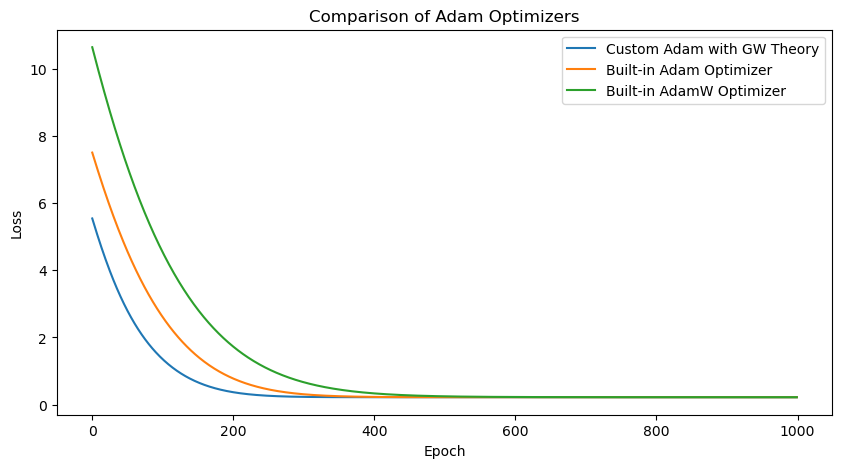

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

np.random.seed(42)
torch.manual_seed(42)

# Generate synthetic data
x = np.random.randn(100)
y = 2 * x + 3 + np.random.randn(100) * 0.5  # true slope is 2, intercept is 3
x = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Define a simple linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)


class AdamOptimizerWithGWTheory(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        
        defaults = dict(lr=lr, betas=betas, eps=eps, base_lr=lr)
        super(AdamOptimizerWithGWTheory, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    state['last_persistence'] = 1

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])

                step_size = group['base_lr'] * (np.sqrt(1 - beta2 ** state['step']) / (1 - beta1 ** state['step']))

                # Calculate persistence and adjust learning rate dynamically
                norm = p.data.norm().item()
                persistence = np.exp(-0.5 * norm)
                if persistence < state['last_persistence']:
                    step_size *= 1.25
                else:
                    step_size *= 0.75
                state['last_persistence'] = persistence

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss


# Training setup
model = LinearRegressionModel()
criterion = nn.MSELoss()

# Using the custom optimizer
optimizer_custom = AdamOptimizerWithGWTheory(model.parameters(), lr=0.01)
# Using the built-in Adam optimizer
optimizer_adam = optim.Adam(model.parameters(), lr=0.01)
# Using the built-in AdamW optimizer
optimizer_adamw = optim.AdamW(model.parameters(), lr=0.01)

# Training loop
def train_model(optimizer, epochs=1000):
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    return losses

# Train with custom optimizer
print("Training with custom Adam optimizer with GW theory:")
losses_custom = train_model(optimizer_custom)

# Reset model and optimizer
model = LinearRegressionModel()
optimizer_adam = optim.Adam(model.parameters(), lr=0.01)

# Train with built-in Adam optimizer
print("Training with built-in Adam optimizer:")
losses_adam = train_model(optimizer_adam)

# Reset model and optimizer
model = LinearRegressionModel()
optimizer_adamw = optim.AdamW(model.parameters(), lr=0.01)

# Train with built-in AdamW optimizer
print("Training with built-in AdamW optimizer:")
losses_adamw = train_model(optimizer_adamw)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(losses_custom, label='Custom Adam with GW Theory')
plt.plot(losses_adam, label='Built-in Adam Optimizer')
plt.plot(losses_adamw, label='Built-in AdamW Optimizer')
plt.title("Comparison of Adam Optimizers")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


Training with custom Adam optimizer with GW theory:
Epoch [1/20], Loss: 0.3057
Epoch [2/20], Loss: 0.1402
Epoch [3/20], Loss: 0.1061
Epoch [4/20], Loss: 0.0856
Epoch [5/20], Loss: 0.0750
Epoch [6/20], Loss: 0.0651
Epoch [7/20], Loss: 0.0574
Epoch [8/20], Loss: 0.0517
Epoch [9/20], Loss: 0.0478
Epoch [10/20], Loss: 0.0441
Epoch [11/20], Loss: 0.0381
Epoch [12/20], Loss: 0.0373
Epoch [13/20], Loss: 0.0353
Epoch [14/20], Loss: 0.0335
Epoch [15/20], Loss: 0.0311
Epoch [16/20], Loss: 0.0285
Epoch [17/20], Loss: 0.0297
Epoch [18/20], Loss: 0.0228
Epoch [19/20], Loss: 0.0256
Epoch [20/20], Loss: 0.0247
Training with built-in Adam optimizer:
Epoch [1/20], Loss: 0.3115
Epoch [2/20], Loss: 0.1424
Epoch [3/20], Loss: 0.1057
Epoch [4/20], Loss: 0.0861
Epoch [5/20], Loss: 0.0697
Epoch [6/20], Loss: 0.0634
Epoch [7/20], Loss: 0.0560
Epoch [8/20], Loss: 0.0494
Epoch [9/20], Loss: 0.0461
Epoch [10/20], Loss: 0.0415
Epoch [11/20], Loss: 0.0376
Epoch [12/20], Loss: 0.0353
Epoch [13/20], Loss: 0.0328
Epo

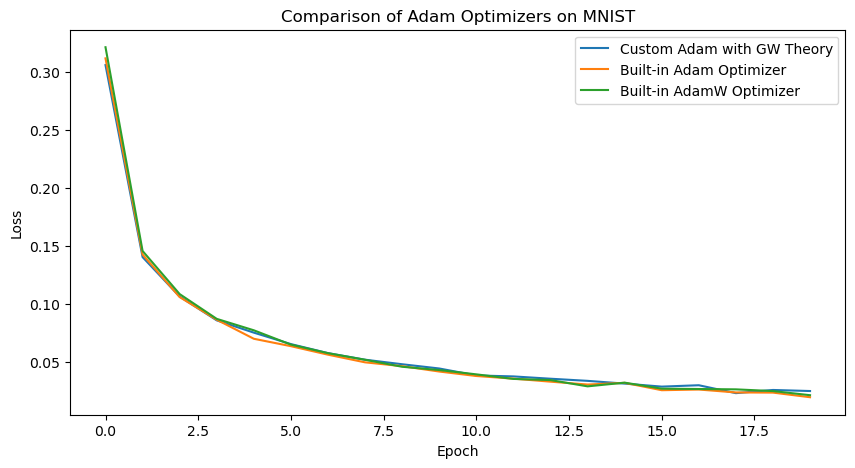

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

torch.cuda.is_available()

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

# Define a simple neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training function
def train_model(model, optimizer, criterion, trainloader, epochs=20):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    return losses

# Testing function
def test_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Initialize model, criterion, and optimizers
model_custom = Net()
model_adam = Net()
model_adamw = Net()

criterion = nn.CrossEntropyLoss()

optimizer_custom = AdamOptimizerWithGWTheory(model_custom.parameters(), lr=0.001)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)
optimizer_adamw = optim.AdamW(model_adamw.parameters(), lr=0.001)

# Train and test models
print("Training with custom Adam optimizer with GW theory:")
losses_custom = train_model(model_custom, optimizer_custom, criterion, trainloader)

print("Training with built-in Adam optimizer:")
losses_adam = train_model(model_adam, optimizer_adam, criterion, trainloader)

print("Training with built-in AdamW optimizer:")
losses_adamw = train_model(model_adamw, optimizer_adamw, criterion, trainloader)

# Test accuracy
accuracy_custom = test_model(model_custom, testloader)
accuracy_adam = test_model(model_adam, testloader)
accuracy_adamw = test_model(model_adamw, testloader)

print(f"Custom Adam with GW Theory Accuracy: {accuracy_custom:.2f}%")
print(f"Built-in Adam Accuracy: {accuracy_adam:.2f}%")
print(f"Built-in AdamW Accuracy: {accuracy_adamw:.2f}%")

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(losses_custom, label='Custom Adam with GW Theory')
plt.plot(losses_adam, label='Built-in Adam Optimizer')
plt.plot(losses_adamw, label='Built-in AdamW Optimizer')
plt.title("Comparison of Adam Optimizers on MNIST")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [33]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


0.209729 M parameters
step 0: train loss 4.4116, val loss 4.4022
step 100: train loss 2.6568, val loss 2.6670
step 200: train loss 2.5091, val loss 2.5059
step 300: train loss 2.4195, val loss 2.4337
step 400: train loss 2.3500, val loss 2.3562


KeyboardInterrupt: 